<a href="https://colab.research.google.com/github/Lucs1590/study_segmentation/blob/main/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

-  Semantic segmentation and COVID-19 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7605758/


# Libraries Import

In [1]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
tensorflow.__version__

'2.8.2'

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Dataset

- **Data Science Bowl de 2018** - https://www.kaggle.com/c/data-science-bowl-2018

In [3]:
os.environ['KAGGLE_USERNAME'] = 'gabevr'
os.environ['KAGGLE_KEY'] = 'ca479e66ac6ae221b62be68f056aca65'

In [4]:
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:12<00:00, 43.7MB/s]
100% 358M/358M [00:12<00:00, 30.5MB/s]


In [5]:
!unzip data-science-bowl-2018.zip -d /content/data-science-bowl-2018

Archive:  data-science-bowl-2018.zip
  inflating: /content/data-science-bowl-2018/stage1_sample_submission.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_solution.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_test.zip  
  inflating: /content/data-science-bowl-2018/stage1_train.zip  
  inflating: /content/data-science-bowl-2018/stage1_train_labels.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_sample_submission_final.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_test_final.zip  


In [6]:
!unzip /content/data-science-bowl-2018/stage1_train.zip -d /content/train/
!unzip /content/data-science-bowl-2018/stage1_test.zip -d /content/test/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d86ee01921b1c9ed23c342952253682060512483c39c8b7b5c6d8350f6df2568.png  
  inflating: /content/train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: /content/train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: /content/train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: /content/train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: /content/train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd

# Images Loading

In [7]:
img_width = 256
img_height = 256
img_channels = 3

In [8]:
seed = 27
np.random.seed = seed
random.seed = seed
train_path = 'train/'
test_path = 'test/'

In [9]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [10]:
len(train_ids), len(test_ids)

(670, 65)

In [11]:
dataset_img = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
dataset_mask = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [12]:
dataset_img.shape, dataset_mask.shape

((670, 256, 256, 3), (670, 256, 256, 1))

# Images Preprocessing

In [13]:
print('Resize training images and masks')
for idx, id_, in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = f'{train_path}{id_}'
  #print(path)
  if "." in path: # .ipynb_checkpoints
    continue

  img = cv2.imread(f'{path}/images/{id_}.png')[:,:,:img_channels]
  img = cv2.resize(img, (img_height, img_width))
  dataset_img[idx] = img
  mask = np.zeros((img_height, img_width, 1), dtype=np.bool)

  for mask_file in next(os.walk(f'{path}/masks/'))[2]:
    mask_ = cv2.imread(f'{path}/masks/{mask_file}')
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
    mask_ = np.expand_dims(cv2.resize(mask_, (img_height, img_width)), axis = -1)
    mask = np.maximum(mask, mask_)
  
  dataset_mask[idx] = mask

Resize training images and masks


  0%|          | 0/670 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 670/670 [00:54<00:00, 12.40it/s]


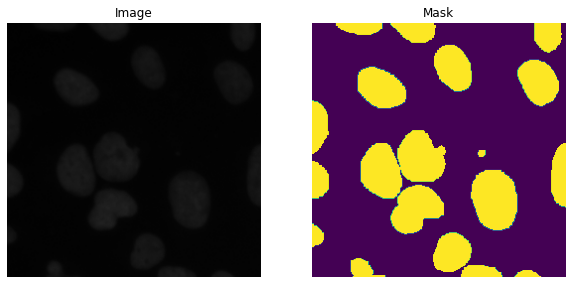

In [14]:
img_id = 27
fig = plt.figure(figsize=(10,7))

fig.add_subplot(1,2,1)
plt.imshow(dataset_img[img_id])
plt.axis('off')
plt.title('Image')

fig.add_subplot(1,2,2)
plt.imshow(np.squeeze(dataset_mask[img_id]))
plt.axis('off')
plt.title('Mask');

In [15]:
X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
redim_test = []
print('Resize Test Images') 
for idx, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    if "." in path:
        continue

    path = f'{test_path}{id_}'
    img = cv2.imread(f'{path}/images/{id_}.png')[:,:,:img_channels]
    redim_test.append([img.shape[0], img.shape[1]])
    img = cv2.resize(img, (img_height, img_width))
    X_test[idx] = img

print('\nDone')
print(X_test.shape)

Resize Test Images


100%|██████████| 65/65 [00:00<00:00, 227.70it/s]


Done
(65, 256, 256, 3)


In [16]:
# Train, Validation, Test
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask, test_size = 0.10, random_state = 27)

In [17]:
X_train.shape

(603, 256, 256, 3)

In [18]:
X_val.shape

(67, 256, 256, 3)

In [19]:
y_train.shape

(603, 256, 256, 1)

In [20]:
y_val.shape

(67, 256, 256, 1)

# Neural Network Building

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

## Convolution

In [22]:
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow/
def convolution_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

## Encoder

In [23]:
def encoder_block(input, num_filters):
  x = convolution_block(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

## Decoder

In [24]:
def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = convolution_block(x, num_filters)
  return x

## Final Models

In [25]:
def unet_model(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = convolution_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs, outputs, name='UNet')
  return model

In [26]:
model = unet_model((img_height, img_width, img_channels))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [27]:
model_file = 'unet_model.json'
modelo_json = model.to_json()
with open(model_file, 'w') as json_file:
  json_file.write(modelo_json)

## Callbacks

In [28]:
model_name = 'unet_model.h5'
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience = 5, monitor='val_loss')
callbacks = [checkpointer, early_stopper]

# Training

In [29]:
epochs = 15
batch_size = 8

In [30]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/15
76/76 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8974
Epoch 1: val_loss improved from inf to 0.49154, saving model to unet_model.h5
76/76 [==============================] - 36s 275ms/step - loss: 0.3297 - accuracy: 0.8974 - val_loss: 0.4915 - val_accuracy: 0.8739
Epoch 2/15
76/76 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9617
Epoch 2: val_loss improved from 0.49154 to 0.27298, saving model to unet_model.h5
76/76 [==============================] - 19s 251ms/step - loss: 0.1623 - accuracy: 0.9617 - val_loss: 0.2730 - val_accuracy: 0.9568
Epoch 3/15
76/76 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9655
Epoch 3: val_loss did not improve from 0.27298
76/76 [==============================] - 18s 242ms/step - loss: 0.1354 - accuracy: 0.9655 - val_loss: 0.5678 - val_accuracy: 0.7388
Epoch 4/15
76/76 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9663
Epoch 4: val_loss imp

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
def show_graphs(history):
  fig = plt.gcf()
  fig.set_size_inches(16,4)
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], 'red', label='Accuracy (Train)')
  plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy (Validation)')
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], 'red', label='Loss (Train)')
  plt.plot(history.history['val_loss'], 'blue', label='Loss (Validation)')
  plt.legend()
  plt.title('Loss')
  plt.show()

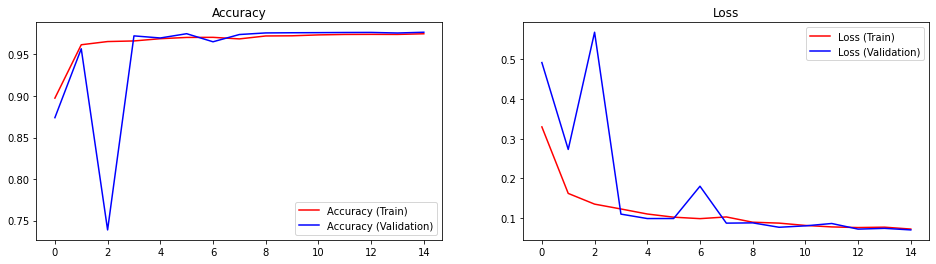

In [33]:
show_graphs(history)

# Tests

## Validation Images

In [34]:
len(X_val)

67

In [35]:
val_pred = model.predict(X_val)

In [36]:
val_pred.shape # sigmoide

(67, 256, 256, 1)

In [37]:
val_pred[27].min(), val_pred[27].max()

(0.0030252351, 1.0)

In [38]:
val_pred = (val_pred > 0.5).astype(np.uint8)
val_pred

array([[[[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[0],
         [0],
         [1],
         ...,
         [0],
         [0],
         [0]],

        [[1],
         [1],
         [1],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [1],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [39]:
np.unique(val_pred[27], return_counts=True)

(array([0, 1], dtype=uint8), array([63228,  2308]))

In [40]:
def compare_segmentations(raw, ground_truth, prediction):
  fig = plt.figure(figsize=(12, 7))

  fig.add_subplot(1,3,1) 
  plt.imshow(raw)
  plt.axis("off")
  plt.title("Raw Image")

  fig.add_subplot(1,3,2) 
  plt.imshow(ground_truth)
  plt.axis("off")
  plt.title("Ground Truth)")

  fig.add_subplot(1,3,3) 
  plt.imshow(prediction)
  plt.axis("off")
  plt.title("Prediction")

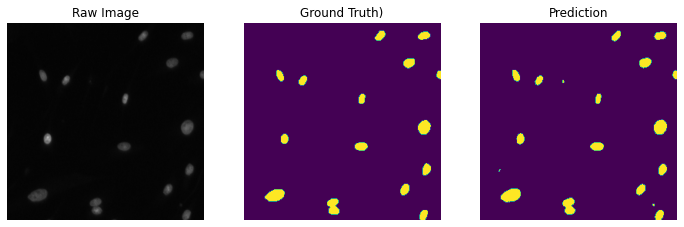

In [41]:
idx = 27
compare_segmentations(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(val_pred[idx]))

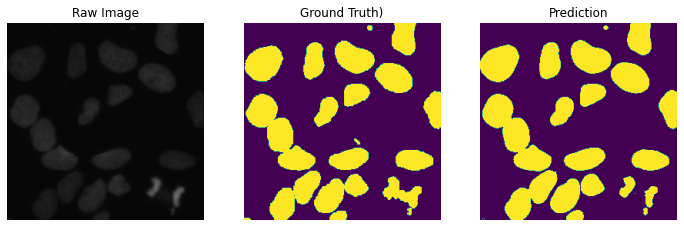

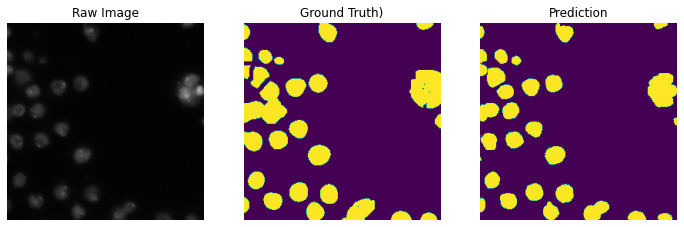

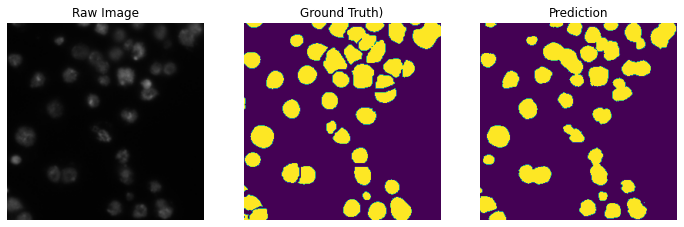

In [42]:
imgs_teste = np.random.choice(len(X_val), 3)
for img_id in imgs_teste:
  compare_segmentations(X_val[img_id], np.squeeze(y_val[img_id]), np.squeeze(val_pred[img_id]))

## Test Images

In [43]:
test_pred = model.predict(X_test)
test_pred = (test_pred > 0.5).astype(np.uint8)

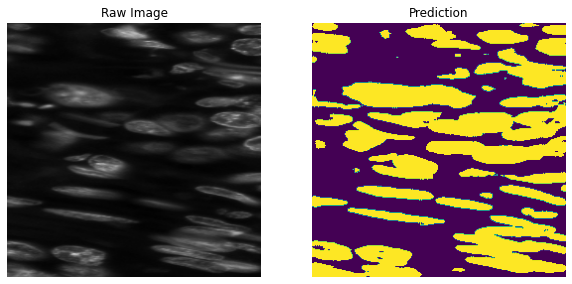

In [44]:
idx = random.randint(0, len(X_test))

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1,2,1) 
plt.imshow(X_test[idx])
plt.axis("off")
plt.title("Raw Image")

fig.add_subplot(1,2,2) 
plt.imshow(np.squeeze(test_pred[idx]))
plt.axis("off")
plt.title("Prediction");

# Evaluation

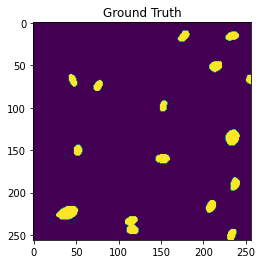

In [45]:
id_test_img = 27
img_test = X_val[id_test_img]
ground_truth = y_val[id_test_img]
plt.imshow(np.squeeze(ground_truth))
plt.title('Ground Truth');

In [53]:
from tensorflow.keras.metrics import MeanIoU
iou_result = MeanIoU(num_classes = 2)

In [47]:
img_test.shape

(256, 256, 3)

In [48]:
test_input_img = np.expand_dims(img_test, 0)
test_input_img.shape

(1, 256, 256, 3)

In [49]:
prediction = (model.predict(test_input_img)[0,:,:,0] > 0.5).astype(np.uint8)

In [50]:
prediction

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [51]:
ground_truth.shape, ground_truth[:,:,0].shape

((256, 256, 1), (256, 256))

IoU value:  0.95020515


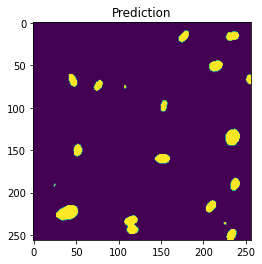

In [54]:
plt.imshow(prediction)
plt.title('Prediction')
iou_result.update_state(ground_truth[:,:,0], prediction)
print('IoU value: ', iou_result.result().numpy())

In [55]:
import pandas as pd

IoU_results = []
for idx in range(0, X_val.shape[0]):
    img = X_val[idx] 
    ground_truth = y_val[idx]
    IoU = MeanIoU(num_classes=2)

    test_input_img=np.expand_dims(img, 0)
    predicao = (model.predict(test_input_img)[0,:,:,0] > 0.5).astype(np.uint8)
    IoU.update_state(ground_truth[:,:,0], predicao)
    IoU_result = IoU.result().numpy() 
    IoU_results.append(IoU_result)
    print(IoU_result)

0.7184943
0.9695834
0.9189031
0.894428
0.90833676
0.9626728
0.9607073
0.89387596
0.94550085
0.8198384
0.8308959
0.97093546
0.92105037
0.92425203
0.94066143
0.9496234
0.9387357
0.9810679
0.96690583
0.86112535
0.9449171
0.8220083
0.952285
0.9473212
0.9576118
0.76700175
0.936515
0.95020515
0.91763026
0.88066643
0.4924974
0.49689302
0.88755316
0.9602542
0.931548
0.9157263
0.4967296
0.8592167
0.95811415
0.9505541
0.94967175
0.9638963
0.88211125
0.8916664
0.7919104
0.8875165
0.96055627
0.92150223
0.9682688
0.8296255
0.9022355
0.94943684
0.9109286
0.8436612
0.9565868
0.9674446
0.86352116
0.801479
0.9508201
0.95078754
0.97215855
0.4899843
0.9510418
0.59471285
0.78786016
0.9538102
0.876397


In [57]:
df = pd.DataFrame(IoU_results, columns=["IoU"])
df = df[df.IoU != 1.0]    
df

,IoU
0,0.718494
1,0.969583
2,0.918903
3,0.894428
4,0.908337
...,...
62,0.951042
63,0.594713
64,0.787860
65,0.953810


In [59]:
IoU_avg = df.mean().values
print(f"IoU Average for {len(IoU_results)} images: ", IoU_avg)  

IoU Average for 67 images:  [0.8816781]


# Save and load model

In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [60]:
model_name

'unet_model.h5'

In [62]:
!cp /content/unet_model.h5 /content/gdrive/MyDrive/Projetos/colab-tests/unet_model.h5
!cp /content/unet_model.json /content/gdrive/MyDrive/Projetos/colab-tests/unet_model.json

In [63]:
from tensorflow.keras.models import model_from_json

In [65]:
json_file = open('/content/unet_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2 = model_from_json(loaded_model_json)

In [67]:
model_2.load_weights('/content/unet_model.h5')

In [68]:
model_2.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

1/1 [==============================] - 0s 32ms/step


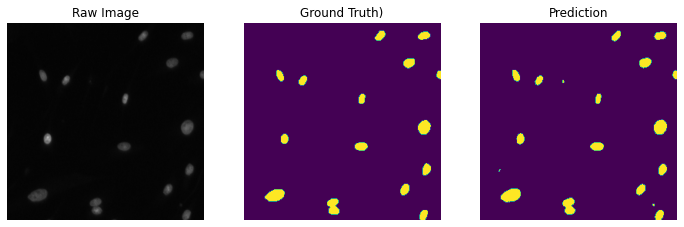

In [76]:
idx = 27

test_img = np.expand_dims(X_val[idx], 0)
val_pred = model_2.predict(test_img, verbose=1)
val_pred = (val_pred > 0.5).astype(np.uint8)

compare_segmentations(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(val_pred))